In [1]:
import os, sys

pathModules = "C:\\Alexandre\\M2 - IPP Sorbonne\\Project_fracture\\code\\modules"
assert os.path.isdir(pathModules)

sys.path.append(pathModules)
pathModules

'C:\\Alexandre\\M2 - IPP Sorbonne\\Project_fracture\\code\\modules'

In [2]:
import numpy as np

import matplotlib.pyplot as plt

import time_to_H as time_to_H
import compute_flexion as flex
import parameters as setup

In [38]:
# Experiments to read

pathData = "C:\\Alexandre\\M2 - IPP Sorbonne\\Project_fracture\\data\\"
list_muDIC_path = [
    pathData + "h_1p5cm\\tauC_100Pa\\1_CCGM_500um_375nm_45uN_100Pa_h_1p5cm_m_137g\\muDIC_fromPreProcessed_blur", 
    pathData + "h_1p5cm\\tauC_115Pa\\1_CCGM_500um_590nm_52uN_115Pa-h_1p5cm_m_134g\\muDIC_fromPreProcessed",
    pathData + "h_1p5cm\\tauC_120Pa\\1_CCGM_500um_793nm_55uN_120Pa-h_1p5cm_m_128g\\muDIC_fromPreProcessed"
]

list_tauC = [100, 115, 120]
list_dtcamera = [0.1, 0.1, 0.1]

nbExp = len(list_muDIC_path)
assert np.all([os.path.isdir(path) for path in list_muDIC_path])

In [39]:
# Read the data

list_coords = []
list_engStrainXX = []
list_frames = []
list_heights = []

for path, dt_camera in zip(list_muDIC_path, list_dtcamera):
    list_coords.append(np.load(os.path.join(path, "coords.npy")))
    list_engStrainXX.append(np.load(os.path.join(path, "engStrainXX_corrected_Xt.npy")))
    
    frames_true = np.load(os.path.join(path, "frames.npy"))[:list_coords[-1].shape[-1]]
    heights = time_to_H.frames_to_H(frames_true, dt_camera, Hmax=setup.Hmax, vMax=setup.vmax, aMax=setup.amax)

    list_frames.append(frames_true)
    list_heights.append(heights)

## Compare the rugosity

In [40]:
# Compute the rugosity stats and curvature

# Mask limits (in pix)
xMin, xMax = 800, 1600
yMin, yMax = 500, 1200

list_rugosity = []
list_curvature = []

for i in range(nbExp):
    coords = list_coords[i]
    engStrainXX = list_engStrainXX[i]
    heights = list_heights[i]

    kappaMax = np.array([flex.solve_curvature(setup.W, H, setup.a)[1] for H in heights])
    list_curvature.append(kappaMax)

    x0 = coords[0,0,:,:,0]
    y0 = coords[0,1,:,:,0]

    maskX = (xMin < x0[:,0]) & (x0[:,0] < xMax)
    maskY = (yMin < y0[0,:]) & (y0[0,:] < yMax)
    maskStats = np.ix_(maskX, maskY)

    rugosity = engStrainXX[maskStats[0], maskStats[1],:].std(axis=(0,1))
    list_rugosity.append(rugosity)

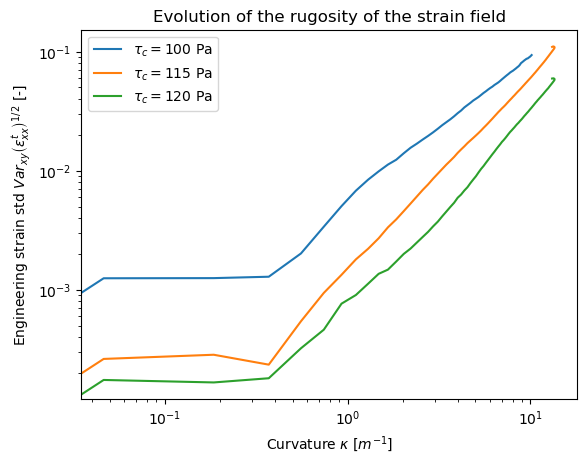

In [45]:
# Plot rugosity evolution with curvature

fig, ax = plt.subplots()
ax.set_title('Evolution of the rugosity of the strain field')

for i in range(nbExp):
    label = "$\\tau_c = $" + f"{list_tauC[i]} Pa"
    ax.plot(list_curvature[i], list_rugosity[i], label=label)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Curvature $\\kappa$ [$m^{-1}$]')
ax.set_ylabel("Engineering strain std $Var_{xy} \\left( \epsilon^t_{xx} \\right)^{1/2}$ [-]")

ax.legend()
plt.show()